# Data preparation

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

## Treasury bond rates

https://finance.yahoo.com/bonds/

- ^IRX : 13 week Treasury Bill
- ^FVX : Treasury Yield 5 years
- ^TNX : Treasury Yield 10 years
- ^TYX : Treasury Yield 30 years

- Scale : %
- frequency : daily (B)

In [2]:
treasury_bonds = ["^IRX", "^FVX", "^TNX", "^TYX"]

tb = yf.Tickers(treasury_bonds)
df_tb = tb.history(period="max")["Close"]

df_tb.rename(columns={"^IRX":"13W", "^FVX":"5Y", "^TNX":"10Y", "^TYX":"30Y"}, inplace=True)
df_tb.tail()

[*********************100%***********************]  4 of 4 completed


,5Y,13W,10Y,30Y
Date,,,,
2023-08-28,4.412,5.323,4.212,4.291
2023-08-29,4.277,5.320,4.122,4.237
2023-08-30,4.273,5.315,4.118,4.228
2023-08-31,4.244,5.298,4.093,4.204
2023-09-01,4.291,5.268,4.173,4.285


## Tesla stock price

In [3]:
tesla = yf.Ticker("TSLA")
df_tesla = tesla.history(period="max")[["Close"]]
df_tesla.tail()

,Close
Date,
2023-08-28 00:00:00-04:00,238.820007
2023-08-29 00:00:00-04:00,257.179993
2023-08-30 00:00:00-04:00,256.899994
2023-08-31 00:00:00-04:00,258.079987
2023-09-01 00:00:00-04:00,245.009995


## FED Fund rates

- Source : https://fred.stlouisfed.org/series/FEDFUNDS
- frequency : monthly
- path : './datasets/FEDFUNDS.csv'

In [4]:
df_fed = pd.read_csv('./datasets/FEDFUNDS.csv')

# set "DATE" column to index
df_fed.set_index("DATE", inplace=True)
# convert index to datetime index
df_fed.index = pd.to_datetime(df_fed.index, utc=True)

df_fed.head()

,FEDFUNDS
DATE,
1954-07-01 00:00:00+00:00,0.80
1954-08-01 00:00:00+00:00,1.22
1954-09-01 00:00:00+00:00,1.07
1954-10-01 00:00:00+00:00,0.85
1954-11-01 00:00:00+00:00,0.83


## Integrate dataframes

### Daily data

In [5]:
df_tb.index = pd.to_datetime(df_tb.index, utc=True).strftime("%Y-%m-%d")
df_tesla.index = pd.to_datetime(df_tesla.index, utc=True).strftime("%Y-%m-%d")

df_daily = pd.merge(df_tb, df_tesla, how="inner", left_index=True, right_index=True)
df_daily.rename(columns={"Close":"Price"}, inplace=True)
df_daily.index = pd.to_datetime(df_daily.index, utc=True)
df_daily.head()

,5Y,13W,10Y,30Y,Price
Date,,,,,
2010-06-29 00:00:00+00:00,1.786,0.160,2.967,3.946,1.592667
2010-06-30 00:00:00+00:00,1.795,0.170,2.951,3.909,1.588667
2010-07-01 00:00:00+00:00,1.795,0.165,2.927,3.868,1.464000
2010-07-02 00:00:00+00:00,1.812,0.160,2.979,3.941,1.280000
2010-07-06 00:00:00+00:00,1.760,0.160,2.932,3.892,1.074000


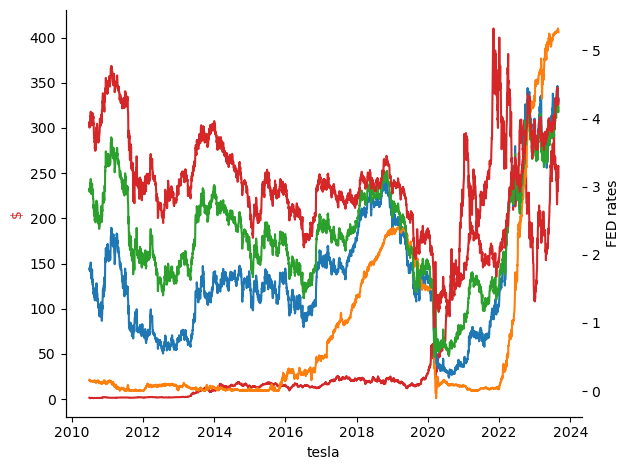

In [6]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('tesla')
ax1.set_ylabel('$', color=color)
ax1.plot(df_daily.index, df_daily["Price"], color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('FED rates')
ax2.plot(df_daily.index, df_daily[["5Y", "13W", "10Y", "30Y"]])

fig.tight_layout()
sns.despine()

In [7]:
df_monthly = pd.merge(df_fed, df_daily, how="inner", left_index=True, right_index=True)
df_monthly.head()

,FEDFUNDS,5Y,13W,10Y,30Y,Price
2010-07-01 00:00:00+00:00,0.18,1.795,0.165,2.927,3.868,1.464000
2010-09-01 00:00:00+00:00,0.19,1.409,0.130,2.582,3.662,1.363333
2010-10-01 00:00:00+00:00,0.19,1.271,0.150,2.526,3.721,1.373333
2010-11-01 00:00:00+00:00,0.19,1.163,0.105,2.628,4.017,1.427333
2010-12-01 00:00:00+00:00,0.18,1.622,0.155,2.964,4.237,2.290000


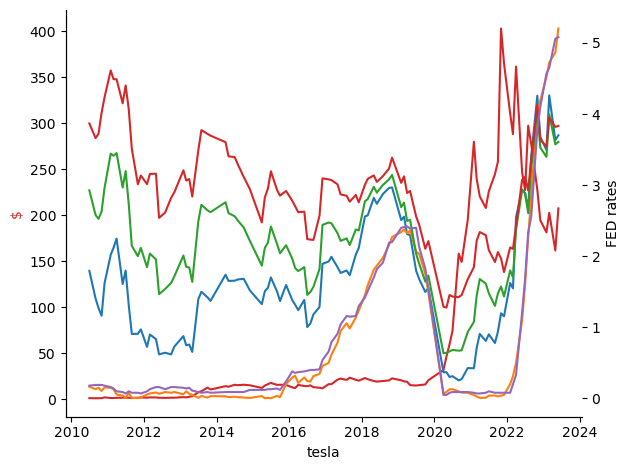

In [8]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('tesla')
ax1.set_ylabel('$', color=color)
ax1.plot(df_monthly.index, df_monthly["Price"], color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('FED rates')
ax2.plot(df_monthly.index, df_monthly[["5Y", "13W", "10Y", "30Y", "FEDFUNDS"]])

fig.tight_layout()
sns.despine()

# Correlation Analysis

## Correlation with Price

### Daily data

In [9]:
# correlation
df_daily.corr()

,5Y,13W,10Y,30Y,Price
5Y,1.000000,0.845532,0.873561,0.558740,0.253429
13W,0.845532,1.000000,0.602524,0.271381,0.316676
10Y,0.873561,0.602524,1.000000,0.886655,0.007907
30Y,0.558740,0.271381,0.886655,1.000000,-0.245222
Price,0.253429,0.316676,0.007907,-0.245222,1.000000


In [10]:
# pearson correlation
cols = df_daily.columns[df_daily.columns != "Price"]
for col in cols:
    corr = stats.pearsonr(df_daily["Price"], df_daily[col])
    print("-", col, ":", corr)
    print("")
    

- 5Y : PearsonRResult(statistic=0.25342859458826344, pvalue=9.566020839999884e-50)

- 13W : PearsonRResult(statistic=0.3166758882595264, pvalue=4.130350793787755e-78)

- 10Y : PearsonRResult(statistic=0.007907267075387612, pvalue=0.64903405109992)

- 30Y : PearsonRResult(statistic=-0.24522219695384073, pvalue=1.3614373131437018e-46)



### Monthly data

In [11]:
df_monthly.corr()

,FEDFUNDS,5Y,13W,10Y,30Y,Price
FEDFUNDS,1.000000,0.828300,0.997624,0.579947,0.253015,0.216192
5Y,0.828300,1.000000,0.836364,0.865706,0.543306,0.180876
13W,0.997624,0.836364,1.000000,0.583874,0.250560,0.241281
10Y,0.579947,0.865706,0.583874,1.000000,0.885427,-0.083016
30Y,0.253015,0.543306,0.250560,0.885427,1.000000,-0.337444
Price,0.216192,0.180876,0.241281,-0.083016,-0.337444,1.000000


In [12]:
# Pearson correlation
cols = df_daily.columns[df_daily.columns != "Price"]

for col in cols:
    corr = stats.pearsonr(df_daily["Price"], df_daily[col])
    print("-", col, ":", corr)
    print("")

- 5Y : PearsonRResult(statistic=0.25342859458826344, pvalue=9.566020839999884e-50)

- 13W : PearsonRResult(statistic=0.3166758882595264, pvalue=4.130350793787755e-78)

- 10Y : PearsonRResult(statistic=0.007907267075387612, pvalue=0.64903405109992)

- 30Y : PearsonRResult(statistic=-0.24522219695384073, pvalue=1.3614373131437018e-46)



### Conclusion

There are no correlations between prices and interest rates.

## Correaltion with Price change rate

### Daily data

In [13]:
# add price change percentage into dataframe

df_daily["percent"] = df_daily["Price"].pct_change()*100
df_daily.dropna(inplace=True)
df_daily.head()

,5Y,13W,10Y,30Y,Price,percent
Date,,,,,,
2010-06-30 00:00:00+00:00,1.795,0.170,2.951,3.909,1.588667,-0.251148
2010-07-01 00:00:00+00:00,1.795,0.165,2.927,3.868,1.464000,-7.847274
2010-07-02 00:00:00+00:00,1.812,0.160,2.979,3.941,1.280000,-12.568307
2010-07-06 00:00:00+00:00,1.760,0.160,2.932,3.892,1.074000,-16.093748
2010-07-07 00:00:00+00:00,1.776,0.155,2.980,3.954,1.053333,-1.924298


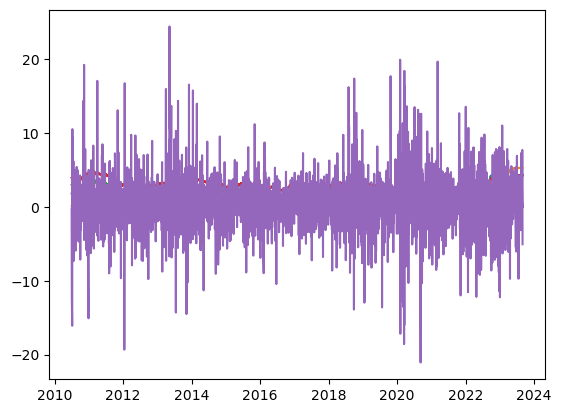

In [14]:
plt.plot(df_daily.index, df_daily[["5Y", "13W", "10Y", "30Y", "percent"]])

In [15]:
df_daily.corr()

,5Y,13W,10Y,30Y,Price,percent
5Y,1.000000,0.845585,0.873644,0.558852,0.253466,-0.045089
13W,0.845585,1.000000,0.602770,0.271681,0.316606,-0.016030
10Y,0.873644,0.602770,1.000000,0.886638,0.008089,-0.045124
30Y,0.558852,0.271681,0.886638,1.000000,-0.245039,-0.031377
Price,0.253466,0.316606,0.008089,-0.245039,1.000000,0.008078
percent,-0.045089,-0.016030,-0.045124,-0.031377,0.008078,1.000000


In [16]:
# Pearson's correlation

cols = df_daily.columns[df_daily.columns != ("Price", "percent")]

for col in cols:
    corr = stats.pearsonr(df_daily["percent"], df_daily[col])
    print("-", col, ":", corr)
    print("")

- 5Y : PearsonRResult(statistic=-0.04508889181422493, pvalue=0.00943190527107644)

- 13W : PearsonRResult(statistic=-0.01603023555928599, pvalue=0.35625253044615207)

- 10Y : PearsonRResult(statistic=-0.04512418816541798, pvalue=0.009376211159922463)

- 30Y : PearsonRResult(statistic=-0.03137741865318714, pvalue=0.07090613468798167)

- Price : PearsonRResult(statistic=0.00807778108324735, pvalue=0.6420398669324743)

- percent : PearsonRResult(statistic=1.0, pvalue=0.0)



5Y, 10Y slightly negative correlation

### Monthly data

In [17]:
# add price change rate

df_monthly["percent"] = df_monthly["Price"].pct_change() * 100
df_monthly.dropna(inplace=True)
df_monthly.head()

,FEDFUNDS,5Y,13W,10Y,30Y,Price,percent
2010-09-01 00:00:00+00:00,0.19,1.409,0.130,2.582,3.662,1.363333,-6.876161
2010-10-01 00:00:00+00:00,0.19,1.271,0.150,2.526,3.721,1.373333,0.733496
2010-11-01 00:00:00+00:00,0.19,1.163,0.105,2.628,4.017,1.427333,3.932041
2010-12-01 00:00:00+00:00,0.18,1.622,0.155,2.964,4.237,2.290000,60.439082
2011-02-01 00:00:00+00:00,0.16,2.021,0.150,3.443,4.613,1.594000,-30.393013


In [18]:
df_monthly.corr()

,FEDFUNDS,5Y,13W,10Y,30Y,Price,percent
FEDFUNDS,1.000000,0.830503,0.997623,0.588133,0.262051,0.213504,-0.192250
5Y,0.830503,1.000000,0.838376,0.867926,0.545506,0.182407,-0.269076
13W,0.997623,0.838376,1.000000,0.591667,0.259103,0.238859,-0.187921
10Y,0.588133,0.867926,0.591667,1.000000,0.884588,-0.077539,-0.262731
30Y,0.262051,0.545506,0.259103,0.884588,1.000000,-0.332637,-0.197120
Price,0.213504,0.182407,0.238859,-0.077539,-0.332637,1.000000,0.037904
percent,-0.192250,-0.269076,-0.187921,-0.262731,-0.197120,0.037904,1.000000


In [19]:
# Peason's correlation

cols = df_monthly.columns[df_monthly.columns != ("Price", "percent")]

for col in cols:
    corr = stats.pearsonr(df_monthly["percent"], df_monthly[col])
    print("-", col, ":", corr)
    print("")

- FEDFUNDS : PearsonRResult(statistic=-0.1922501712494664, pvalue=0.052892170098470796)

- 5Y : PearsonRResult(statistic=-0.26907615649963357, pvalue=0.006244242874807721)

- 13W : PearsonRResult(statistic=-0.18792148699390926, pvalue=0.05856953266379309)

- 10Y : PearsonRResult(statistic=-0.2627305625153188, pvalue=0.007635304798513631)

- 30Y : PearsonRResult(statistic=-0.1971195899468253, pvalue=0.04705510119260959)

- Price : PearsonRResult(statistic=0.03790383528963872, pvalue=0.7052612437358712)

- percent : PearsonRResult(statistic=0.9999999999999996, pvalue=0.0)



### Conclusion

all except 30Y/13W are slightly negative correlation.
5Y > 10Y >> FEDFUNDS >> (30Y > 13W)

# Prediction modeling

## NeuralProphet

### Non stationary data

In [22]:
from neuralprophet import NeuralProphet, set_log_level
# from sklearn.model_selection import train_test_split
set_log_level("ERROR")

In [23]:
# Data adjustmnet

df_new = pd.DataFrame()
df_original = df_daily.reset_index()

df_new = df_original[["Date", "5Y"]]
# df_tb.rename(columns={"^IRX":"13W", "^FVX":"5Y", "^TNX":"10Y", "^TYX":"30Y"}, inplace=True)
df_new.rename(columns={"Date":"ds", "5Y":"y"}, inplace=True)
df_new.head()

WARNING - (py.warnings._showwarnmsg) - /var/folders/dt/q9f0jq252ld5kmwg8rqf4pgw0000gn/T/ipykernel_46312/334945901.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.rename(columns={"Date":"ds", "5Y":"y"}, inplace=True)



,ds,y
0,2010-06-30 00:00:00+00:00,1.795
1,2010-07-01 00:00:00+00:00,1.795
2,2010-07-02 00:00:00+00:00,1.812
3,2010-07-06 00:00:00+00:00,1.760
4,2010-07-07 00:00:00+00:00,1.776


WARNING - (py.warnings._showwarnmsg) - /Users/woojin/miniforge3/envs/neuralprophet/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

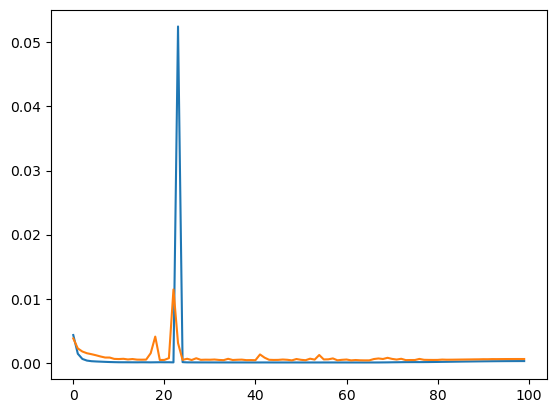

In [24]:
model_neupro = NeuralProphet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    batch_size=64,
    epochs=100,
    learning_rate=0.1,
    n_lags=10,   # add the autoregression
    ar_reg=1    # 1-step ahead forecast with Auto-Regression
)

train, test = model_neupro.split_df(df_new, freq="D", valid_p=0.1)

metrics = model_neupro.fit(train, freq="D", validation_df=test, progress="plot")

In [25]:
metrics.tail()

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,MAE,RMSE,Loss,RegLoss
95,0.051361,0.071486,0.000605,0.000214,95,0.023106,0.034412,0.000280,0.000212
96,0.051141,0.071369,0.000607,0.000217,96,0.023110,0.034379,0.000284,0.000216
97,0.051133,0.071366,0.000609,0.000219,97,0.023072,0.034343,0.000286,0.000218
98,0.051170,0.071385,0.000610,0.000221,98,0.023175,0.034441,0.000289,0.000220
99,0.051112,0.071355,0.000610,0.000221,99,0.023137,0.034417,0.000289,0.000221


In [26]:
# predict

forecast = model_neupro.predict(train)
# model_neupro.set_plotting_backend("plotly-static")
model_neupro.plot(forecast)

Predicting: 68it [00:00, ?it/s]

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)…

In [27]:
forecast = model_neupro.predict(test)
model_neupro = model_neupro.highlight_nth_step_ahead_of_each_forecast(1)
model_neupro.plot(forecast[-5*4*12*1:])

Predicting: 68it [00:00, ?it/s]

FigureWidgetResampler({
    'data': [{'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',…

In [28]:
model_neupro.plot(forecast[['ds', 'y', 'yhat1']])

FigureWidgetResampler({
    'data': [{'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',…

In [29]:
model_neupro.plot_parameters()

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': '#2d92ff', 'width': 2},
…

In [40]:
df_future = pd.DataFrame()
df_future['ds'] = pd.date_range(pd.to_datetime("2023-09-02", utc=True), periods=120)
df_future['y'] = 0
df_future

,ds,y
0,2023-09-02 00:00:00+00:00,0
1,2023-09-03 00:00:00+00:00,0
2,2023-09-04 00:00:00+00:00,0
3,2023-09-05 00:00:00+00:00,0
4,2023-09-06 00:00:00+00:00,0
...,...,...
115,2023-12-26 00:00:00+00:00,0
116,2023-12-27 00:00:00+00:00,0
117,2023-12-28 00:00:00+00:00,0
118,2023-12-29 00:00:00+00:00,0


In [41]:
# Forecast out-of-sample
forecast = model_neupro.predict(df_future)
model_neupro = model_neupro.highlight_nth_step_ahead_of_each_forecast(1)
model_neupro.plot(forecast)

Predicting: 68it [00:00, ?it/s]

FigureWidgetResampler({
    'data': [{'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',…

## Times series - Linear univariate

### TB 5Y Bond rate - non stationary

In [92]:
## Time series - linear univar

%reload_ext autoreload
%autoreload 2
from module_regression import * 
from module_timeseries import *

# Data manipulation 
import requests
from io import BytesIO
import random
from itertools import product
import scipy as sp

# Time series algorithms
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.tsa.statespace import SARIMAX
from pmdarima import AutoARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict

In [93]:
df_daily.head()

,5Y,13W,10Y,30Y,Price,percent
Date,,,,,,
2010-06-30 00:00:00+00:00,1.79,0.17,2.95,3.91,1.59,-0.25
2010-07-01 00:00:00+00:00,1.79,0.17,2.93,3.87,1.46,-7.85
2010-07-02 00:00:00+00:00,1.81,0.16,2.98,3.94,1.28,-12.57
2010-07-06 00:00:00+00:00,1.76,0.16,2.93,3.89,1.07,-16.09
2010-07-07 00:00:00+00:00,1.78,0.16,2.98,3.95,1.05,-1.92


In [94]:
# ## Base algorithm : Linear Regression

# # split data
# Y_colname = ['percent']
# X_colname = ['5Y']
# X_train, X_test, Y_train, Y_test = datasplit_ts(df_daily, Y_colname, X_colname, '2020-07-31')


# # Linear regression
# model_lr = sm.OLS(Y_train, X_train).fit()
# display(model_lr.summary())

# Y_trpred = pd.DataFrame(model_lr.predict(X_train), columns=['Pred'])
# Y_tepred = pd.DataFrame(model_lr.predict(X_test), columns=['Pred'])
# plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:, 1:])
# plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:, 1:])

# # 분석 검증
# Score = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
# display(Score)

# # 에러 분석
# Resid_te = Y_test - Y_tepred.values
# Resid_te.columns = ['Error']
# Error_te = error_analysis_timeseries(X_test, Y_tepred, Resid_te, graph_on=True)
# display(Error_te)

#### Advanced Algorithm : SARIMA

https://github.com/ahn283/finance/blob/main/time_series/lecture02_timeseries_linear_univariate.ipynb

https://github.com/ahn283/finance/blob/main/python_for_finance_cookbook/time_series_analysis_forecasting.ipynb

#### parameter guessing

H0 of ADF:  비정상상태
H0 of KPSS:  정상상태


,Stationarity_ADF,Stationarity_KPSS
Test Statistics,-0.33,1.68
p-value,0.92,0.01
Used Lag,23.00,37.00
Critical Value (1%),-3.43,0.74
Critical Value (5%),-2.86,0.46
Critical Value (10%),-2.57,0.35
Critical Value (2.5%),NaN,0.57


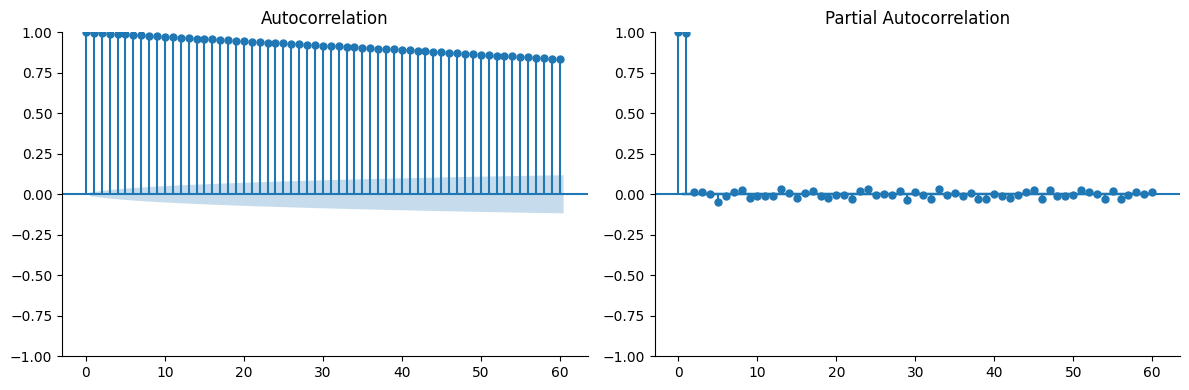

In [95]:
## 정상성 테스트 및 모수추론
sarima_y = pd.DataFrame(df_daily["5Y"])

print('H0 of ADF: ', '비정상상태')
print('H0 of KPSS: ', '정상상태')
display(stationarity_ADF_KPSS(pd.DataFrame(sarima_y.values.flatten())))

plt.figure(figsize=(12, 4))
plot_acf(sarima_y, lags=4*5*3, alpha=0.5, use_vlines=True, ax=plt.subplot(121))
plot_pacf(sarima_y, lags=4*5*3, alpha=0.5, use_vlines=True, ax=plt.subplot(122))
plt.tight_layout()
sns.despine()
plt.show()

#### Train models with grid search

In [114]:
import itertools

# Define the p, d and q paramters to take any value between 0 and 4
## ARMA(p, d, q)
p = d = q = range(2)
## seasonal ARMA(P, D, Q, S)
P = D = Q = range(1)
S = 4*5*3

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q tripliets
seasonal_pdq = [(x[0], x[1], x[2], S) for x in list(itertools.product(P, D, Q))]

In [115]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [116]:
seasonal_pdq

[(0, 0, 0, 60)]

In [99]:
# # choose best AIC parameter (minimum)

# best_aic = np.inf
# best_pdq = None
# best_seasonal_pdq = None
# tmp_model = None
# best_mdl = None
# results = []

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
        # try:
        #     tmp_mdl = SARIMAX(sarima_y.values, exog=None, order=param,
        #                       seasonal_order=param_seasonal,
        #                       enforce_stationarity=True,
        #                       enforce_invertibility=True)
        #     res = tmp_mdl.fit()
        #     print("SARIMAX{}x{},{S} - AIC:{}".format(param, param_seasonal, res.aic))
            
        #     if res.aic < best_aic:
        #         best_aic = res.aic
        #         best_pdq = param
        #         best_seasonal_pdq = param_seasonal
        #         best_mdl = tmp_mdl
        
        # except:
        #     continue

# print("Best SARIMAX{}x{}{} model - AIC:{}".format(best_pdq, best_seasonal_pdq, S, best_aic))

In [117]:
# choose best AIC parameter (minimum)
result = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        if (p == 0) & (q == 0) & (d == 0):
            continue
        
        model = SARIMAX(sarima_y, order=param,
                        seasonal_order=param_seasonal
                        ).fit()
        
        try:
            print("p:", param[0], "d:", param[1], "q:", param[2], "P:", param_seasonal[0], "D:", param_seasonal[1], "Q:", param_seasonal[2], "S:", param_seasonal[3])
            result.append({'p':param[0], 'd':param[1], 'q':param[2], 
                            'P':param_seasonal[0], 'D':param_seasonal[1], 'Q':param_seasonal[2], 'S':param_seasonal[3], 
                            'LLF': model.llf, 'AIC': model.aic, 'BIC': model.bic})
        
        except:
            pass

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.07501D+00    |proj g|=  2.69242D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   2.692D-06   2.075D+00
  F =   2.0750084113425791     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
p: 0 d: 0 q: 0 P: 0 D: 0 Q: 0 S: 60
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at th

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.54266D+00    |proj g|=  2.09599D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2     15      1     0     0   3.122D-04  -1.543D+00
  F =  -1.5426577182077132     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
p: 0 d: 1 q: 0 P: 0 D: 0 Q: 0 S: 60
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.54280D+00 

 This problem is unconstrained.



At iterate   25    f= -1.54154D+00    |proj g|=  1.03398D-02

At iterate   30    f= -1.54192D+00    |proj g|=  6.17028D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     34     52      1     0     0   5.674D-06  -1.542D+00
  F =  -1.5419270262035578     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
p: 1 d: 0 q: 0 P: 0 D: 0 Q: 0 S: 60
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.16833D+02    |proj g|=  2.77731D+04


 This problem is unconstrained.



At iterate    5    f=  1.26736D+00    |proj g|=  5.68881D-01

At iterate   10    f= -1.05736D+00    |proj g|=  3.24701D+00

At iterate   15    f= -1.52289D+00    |proj g|=  4.18371D-01

At iterate   20    f= -1.53615D+00    |proj g|=  8.43090D-02

At iterate   25    f= -1.54160D+00    |proj g|=  8.36584D-03

At iterate   30    f= -1.54205D+00    |proj g|=  1.07969D-02

At iterate   35    f= -1.54207D+00    |proj g|=  5.72652D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     37     56      1     0     0   2.243D-06  -1.542D+00
  F =  -1.5420675681077083     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.54294D+00    |proj g|=  3.13675D-02

At iterate   10    f= -1.54295D+00    |proj g|=  4.58354D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   4.584D-04  -1.543D+00
  F =  -1.5429462351569578     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
p: 1 d: 1 q: 1 P: 0 D: 0 Q: 0 S: 60


,p,d,q,P,D,Q,S,LLF,AIC,BIC
0,0,0,0,0,0,0,60,"-6,876.58","13,755.16","13,761.26"
1,0,0,1,0,0,0,60,"-4,642.66","9,289.32","9,301.53"
2,0,1,0,0,0,0,60,"5,112.37","-10,222.74","-10,216.63"
3,0,1,1,0,0,0,60,"5,112.84","-10,221.68","-10,209.47"
4,1,0,0,0,0,0,60,"5,109.95","-10,215.89","-10,203.68"
5,1,0,1,0,0,0,60,"5,110.41","-10,214.82","-10,196.51"
6,1,1,0,0,0,0,60,"5,112.81","-10,221.62","-10,209.41"
7,1,1,1,0,0,0,60,"5,113.32","-10,220.65","-10,202.33"


( 0 1 0 ) ( 0 0 0 60 )


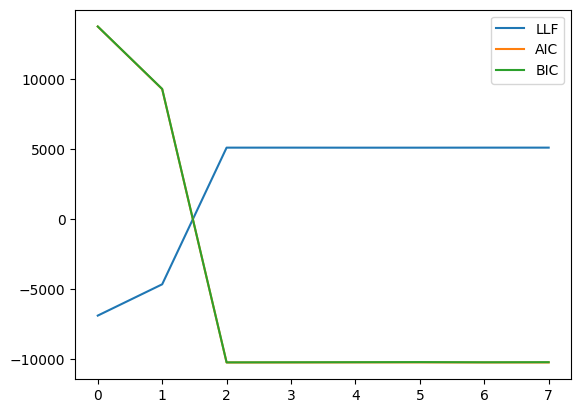

In [118]:
# plot the results
result = pd.DataFrame(result)
display(result)

# AIC, BIC graph
result.iloc[:, -3:].plot()

# optimized aic, bic, best params
opt_p = result.iloc[np.argmin(result['AIC']), 0]
opt_d = result.iloc[np.argmin(result['AIC']), 1]
opt_q = result.iloc[np.argmin(result['AIC']), 2]
opt_P = result.iloc[np.argmin(result['AIC']), 3]
opt_D = result.iloc[np.argmin(result['AIC']), 4]
opt_Q = result.iloc[np.argmin(result['AIC']), 5]
opt_S = result.iloc[np.argmin(result['AIC']), 6]

print("(", opt_p, opt_d, opt_q, ")", "(", opt_P, opt_D, opt_Q, opt_S, ")")

In [119]:
# SARIMA modeling

model = SARIMAX(sarima_y, order=(opt_p, opt_d, opt_q),
                seasonal_order=(opt_P, opt_D, opt_Q, opt_S)).fit()
display(model.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.54266D+00    |proj g|=  2.09599D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2     15      1     0     0   3.122D-04  -1.543D+00
  F =  -1.5426577182077132     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     5Y   No. Observations:                 3314
Model:               SARIMAX(0, 1, 0)   Log Likelihood                5112.368
Date:                Mon, 04 Sep 2023   AIC                         -10222.735
Time:                        00:15:06   BIC                         -10216.630
Sample:                             0   HQIC                        -10220.550
                               - 3314                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0027   4.06e-05     65.930      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):              1478.23
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               1.86   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

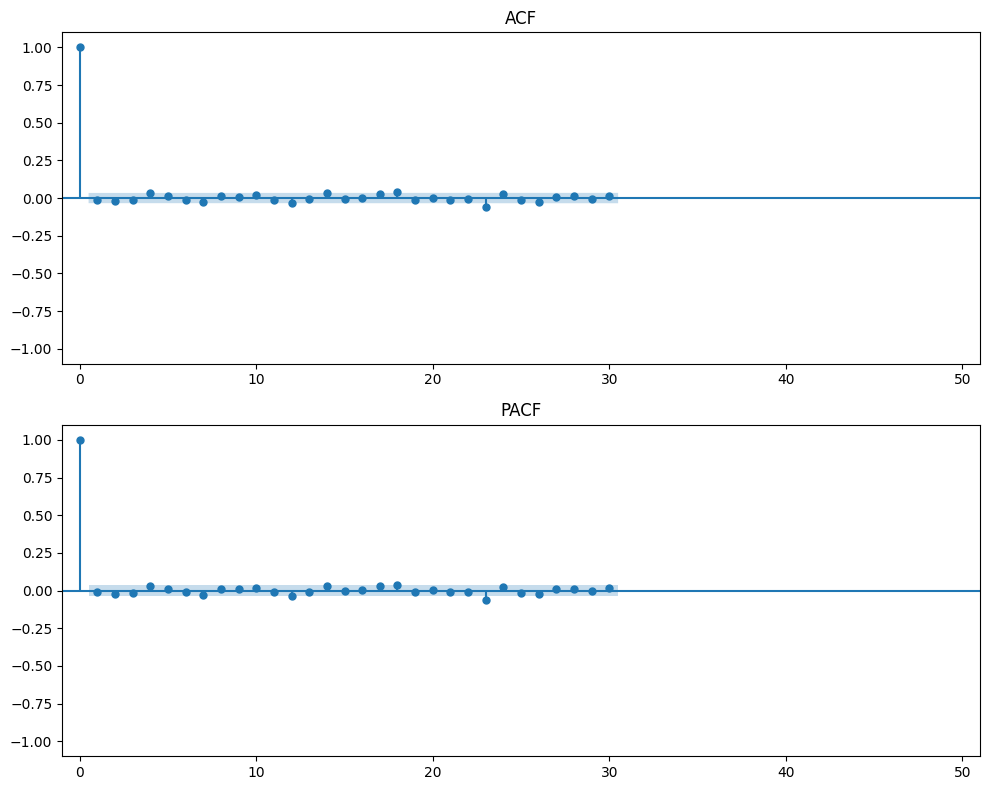

In [120]:
# Residual ACF/PACF
plt.figure(figsize=(10, 8))
plot_acf(model.resid, lags=30, ax=plt.subplot(211))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title('ACF')

plot_pacf(model.resid, lags=30, ax=plt.subplot(212))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title('PACF')
plt.tight_layout()
plt.show()

#### Prediction

In [121]:
sarima_y

,5Y
Date,
2010-06-30 00:00:00+00:00,1.79
2010-07-01 00:00:00+00:00,1.79
2010-07-02 00:00:00+00:00,1.81
2010-07-06 00:00:00+00:00,1.76
2010-07-07 00:00:00+00:00,1.78
...,...
2023-08-28 00:00:00+00:00,4.41
2023-08-29 00:00:00+00:00,4.28
2023-08-30 00:00:00+00:00,4.27


In [122]:
## In-sample-prediction and confidence bounds
pred = model.get_prediction(start=pd.to_datetime('2020-07-30', utc=True),
                            end=pd.to_datetime('2023-09-01', utc=True),
                        #   dynamic=True  # dynamic 파라미터가 true 일 경우, In-sample prediction을 수행할 때, 예측값 대신 실제값을 이용
                            )

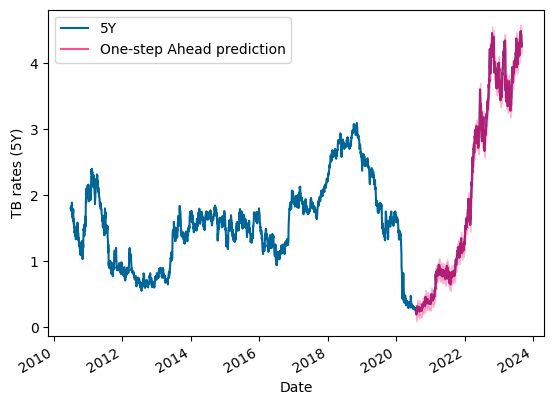

In [123]:
# we can get prediction_mean and prediction confidence level 95%
# pred(get_predict의 결과물)로부터 prediction mean과 prediction 95% 신뢰구간 획득 가능
pred_ci = pred.conf_int()

# pred_ci[1:].plot()

# plot in-sample-prediction
ax = sarima_y.plot(label="Observed", color="#006699")
pred.predicted_mean[1:].plot(ax=ax, label="One-step Ahead prediction", alpha=.7, color="#ff0066")

## Draw confidence bound (gray)
ax.fill_between(pred_ci.index[1:],
                pred_ci.iloc[1:, 0],
                pred_ci.iloc[1:, 1], color='#ff0066', alpha=.25)

## style the plot
# ax.fill_between(ax.get_ylim(), pd.to_datetime('2010-06-30'), sarima_y.index[-1], alpha=.15, zorder=-1,
#                 color='grey')
ax.set_xlabel('Date')
ax.set_ylabel('TB rates (5Y)')
plt.legend(loc='upper left')
plt.show()


#### Forecast - out-of-sample

In [125]:
from datetime import datetime
# get forecast 120 steps ahead in future
forecast = model.get_forecast(steps=120)

## get confidnece intervals of forecasts
forecast_ci = forecast.conf_int()

# set dateitme index to 120 forecasts to the confidence data
dates_future = pd.date_range(pd.to_datetime("2023-09-02", utc=True), periods=120)
forecast_ci['Date'] = dates_future
forecast_ci.set_index('Date', inplace=True)

forecast_ci

,lower 5Y,upper 5Y
Date,,
2023-09-02 00:00:00+00:00,4.19,4.39
2023-09-03 00:00:00+00:00,4.15,4.43
2023-09-04 00:00:00+00:00,4.12,4.47
2023-09-05 00:00:00+00:00,4.09,4.49
2023-09-06 00:00:00+00:00,4.06,4.52
...,...,...
2023-12-26 00:00:00+00:00,3.20,5.38
2023-12-27 00:00:00+00:00,3.19,5.39
2023-12-28 00:00:00+00:00,3.19,5.39


In [126]:
# set dateitme index to 120 forecasts to the mean data
pred_mean = pd.DataFrame(forecast.predicted_mean)
pred_mean['Date'] = dates_future
pred_mean.set_index('Date', inplace=True)
pred_mean

,predicted_mean
Date,
2023-09-02 00:00:00+00:00,4.29
2023-09-03 00:00:00+00:00,4.29
2023-09-04 00:00:00+00:00,4.29
2023-09-05 00:00:00+00:00,4.29
2023-09-06 00:00:00+00:00,4.29
...,...
2023-12-26 00:00:00+00:00,4.29
2023-12-27 00:00:00+00:00,4.29
2023-12-28 00:00:00+00:00,4.29


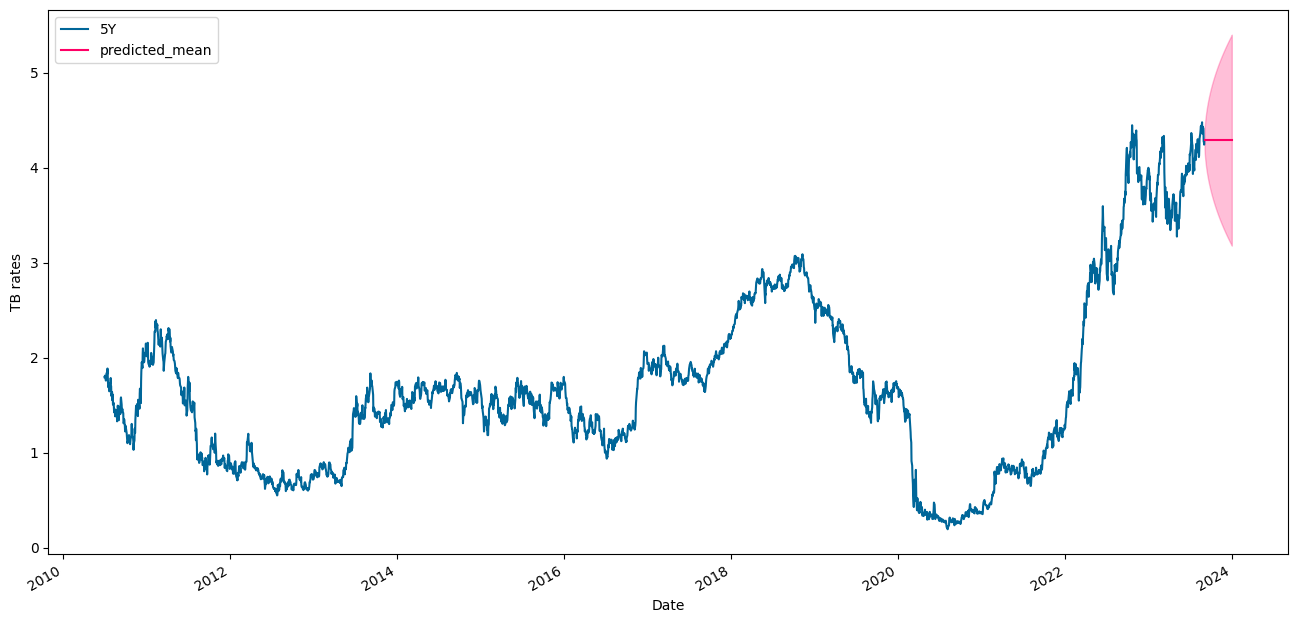

In [127]:
# plot time series and long-term forecast
ax = sarima_y.plot(label='Pbserved', figsize=(16, 8), color='#006699')
pred_mean.plot(ax=ax, label='Forecast', color='#ff0066')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1],
                color='#ff0066', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('TB rates')
plt.legend(loc='upper left')
plt.show()

### TB 5Y Bond rate - Stationary

#### Stataionary analysis

In [139]:
df_tb_5y = pd.DataFrame()

df_tb_5y['5Y'] = df_daily['5Y']
df_tb_5y['diff'] = df_tb_5y['5Y'].diff()
df_tb_5y.dropna(inplace=True)

<Axes: xlabel='Date'>

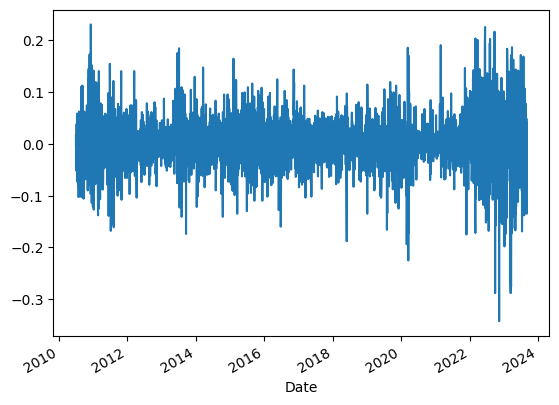

In [140]:
df_tb_5y['diff'].plot()

H0 of ADF:  비정상상태
H0 of KPSS:  정상상태


,Stationarity_ADF,Stationarity_KPSS
Test Statistics,-12.07,0.30
p-value,0.00,0.10
Used Lag,22.00,1.00
Critical Value (1%),-3.43,0.74
Critical Value (5%),-2.86,0.46
Critical Value (10%),-2.57,0.35
Critical Value (2.5%),NaN,0.57


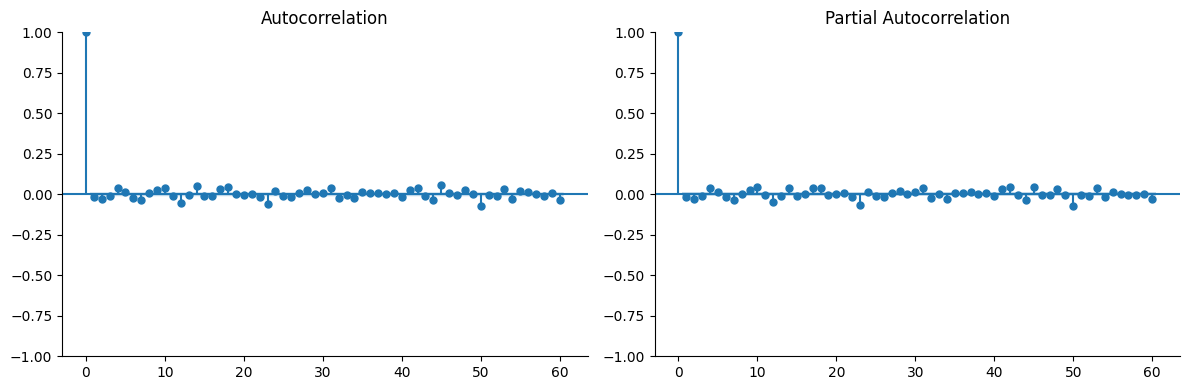

In [141]:
# stationary test

## 정상성 테스트 및 모수추론
sarima_y_diff = pd.DataFrame(df_tb_5y["diff"])

print('H0 of ADF: ', '비정상상태')
print('H0 of KPSS: ', '정상상태')
display(stationarity_ADF_KPSS(pd.DataFrame(sarima_y_diff.values.flatten())))

plt.figure(figsize=(12, 4))
plot_acf(sarima_y_diff, lags=4*5*3, alpha=0.5, use_vlines=True, ax=plt.subplot(121))
plot_pacf(sarima_y_diff, lags=4*5*3, alpha=0.5, use_vlines=True, ax=plt.subplot(122))
plt.tight_layout()
sns.despine()
plt.show()

In [142]:
# choose best AIC parameter (minimum)
result_stationary = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        if (p == 0) & (q == 0) & (d == 0):
            continue
        
        model = SARIMAX(sarima_y, order=param,
                        seasonal_order=param_seasonal
                        ).fit()
        
        try:
            print("p:", param[0], "d:", param[1], "q:", param[2], "P:", param_seasonal[0], "D:", param_seasonal[1], "Q:", param_seasonal[2], "S:", param_seasonal[3])
            result_stationary.append({'p':param[0], 'd':param[1], 'q':param[2], 
                            'P':param_seasonal[0], 'D':param_seasonal[1], 'Q':param_seasonal[2], 'S':param_seasonal[3], 
                            'LLF': model.llf, 'AIC': model.aic, 'BIC': model.bic})
        
        except:
            pass

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.07501D+00    |proj g|=  2.69242D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   2.692D-06   2.075D+00
  F =   2.0750084113425791     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
p: 0 d: 0 q: 0 P: 0 D: 0 Q: 0 S: 60
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at th

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2     39      2     0     0   7.255D-04  -1.543D+00
  F =  -1.5428002740473052     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
p: 0 d: 1 q: 1 P: 0 D: 0 Q: 0 S: 60
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.92468D+02    |proj g|=  2.68348D+04

At iterate    5    f=  1.30078D+00    |proj g|=  5.54956D-01

At iterate   10    f= -1.18055D+00    |proj g|=  1.95524D+00

At iterate   15    f= -1.50419D+0

 This problem is unconstrained.



At iterate   10    f= -1.05736D+00    |proj g|=  3.24701D+00

At iterate   15    f= -1.52289D+00    |proj g|=  4.18371D-01

At iterate   20    f= -1.53615D+00    |proj g|=  8.43090D-02

At iterate   25    f= -1.54160D+00    |proj g|=  8.36584D-03

At iterate   30    f= -1.54205D+00    |proj g|=  1.07969D-02

At iterate   35    f= -1.54207D+00    |proj g|=  5.72652D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     37     56      1     0     0   2.243D-06  -1.542D+00
  F =  -1.5420675681077083     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
p: 1 d: 0 q: 1 P: 0 D: 0 Q: 0 S: 60
RUNNING THE L-B

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2     16      1     0     0   3.607D-04  -1.543D+00
  F =  -1.5427912757979081     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
p: 1 d: 1 q: 0 P: 0 D: 0 Q: 0 S: 60
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.54294D+00    |proj g|=  1.66257D-02

At iterate    5    f= -1.54294D+00    |proj g|=  3.13675D-02

At iterate   10    f= -1.54295D+00    |proj g|=  4.58354D-04

           * * *

Tit   = total n

,p,d,q,P,D,Q,S,LLF,AIC,BIC
0,0,0,0,0,0,0,60,"-6,876.58","13,755.16","13,761.26"
1,0,0,1,0,0,0,60,"-4,642.66","9,289.32","9,301.53"
2,0,1,0,0,0,0,60,"5,112.37","-10,222.74","-10,216.63"
3,0,1,1,0,0,0,60,"5,112.84","-10,221.68","-10,209.47"
4,1,0,0,0,0,0,60,"5,109.95","-10,215.89","-10,203.68"
5,1,0,1,0,0,0,60,"5,110.41","-10,214.82","-10,196.51"
6,1,1,0,0,0,0,60,"5,112.81","-10,221.62","-10,209.41"
7,1,1,1,0,0,0,60,"5,113.32","-10,220.65","-10,202.33"


( 0 1 0 ) ( 0 0 0 60 )


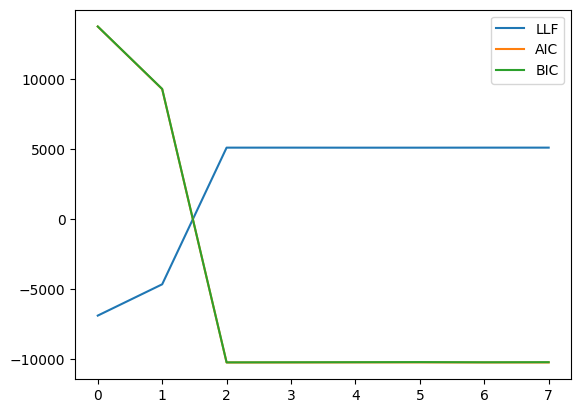

In [143]:
# plot the results
result_stationary = pd.DataFrame(result_stationary)
display(result_stationary)

# AIC, BIC graph
result_stationary.iloc[:, -3:].plot()

# optimized aic, bic, best params
opt_s_p = result.iloc[np.argmin(result['AIC']), 0]
opt_s_d = result.iloc[np.argmin(result['AIC']), 1]
opt_s_q = result.iloc[np.argmin(result['AIC']), 2]
opt_s_P = result.iloc[np.argmin(result['AIC']), 3]
opt_s_D = result.iloc[np.argmin(result['AIC']), 4]
opt_s_Q = result.iloc[np.argmin(result['AIC']), 5]
opt_s_S = result.iloc[np.argmin(result['AIC']), 6]

print("(", opt_s_p, opt_s_d, opt_s_q, ")", "(", opt_s_P, opt_s_D, opt_s_Q, opt_s_S, ")")

In [146]:
# SARIMA modeling with stationary data

model = SARIMAX(sarima_y_diff, order=(opt_s_p, opt_s_d, opt_s_q),
                seasonal_order=(opt_s_P, opt_s_D, opt_s_Q, opt_s_S)).fit()
display(model.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.18799D+00    |proj g|=  2.25507D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2     12      1     0     0   2.545D-04  -1.188D+00
  F =  -1.1879948175946817     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   diff   No. Observations:                 3313
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3935.827
Date:                Mon, 04 Sep 2023   AIC                          -7869.654
Time:                        00:49:05   BIC                          -7863.548
Sample:                             0   HQIC                         -7867.469
                               - 3313                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0054   8.24e-05     66.010      0.000       0.005       0.006
===================================================================================
Ljung-Box (L1) (Q):                 803.66   Jarque-Bera (JB):              1474.12
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.84   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Prediction

In [144]:
sarima_y_diff

,diff
Date,
2010-07-01 00:00:00+00:00,0.00
2010-07-02 00:00:00+00:00,0.02
2010-07-06 00:00:00+00:00,-0.05
2010-07-07 00:00:00+00:00,0.02
2010-07-08 00:00:00+00:00,0.02
...,...
2023-08-28 00:00:00+00:00,-0.02
2023-08-29 00:00:00+00:00,-0.14
2023-08-30 00:00:00+00:00,-0.00


In [148]:
## In-sample-prediction and confidence bounds
pred_s = model.get_prediction(start=pd.to_datetime('2020-07-30', utc=True),
                            end=pd.to_datetime('2023-09-01', utc=True),
                        #   dynamic=True  # dynamic 파라미터가 true 일 경우, In-sample prediction을 수행할 때, 예측값 대신 실제값을 이용
                            )

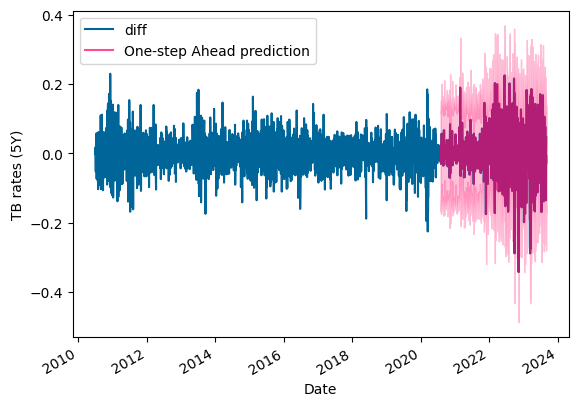

In [149]:
# we can get prediction_mean and prediction confidence level 95%
# pred(get_predict의 결과물)로부터 prediction mean과 prediction 95% 신뢰구간 획득 가능
pred_s_ci = pred_s.conf_int()

# pred_ci[1:].plot()

# plot in-sample-prediction
ax = sarima_y_diff.plot(label="Observed", color="#006699")
pred_s.predicted_mean[1:].plot(ax=ax, label="One-step Ahead prediction", alpha=.7, color="#ff0066")

## Draw confidence bound (gray)
ax.fill_between(pred_s_ci.index[1:],
                pred_s_ci.iloc[1:, 0],
                pred_s_ci.iloc[1:, 1], color='#ff0066', alpha=.25)

## style the plot
# ax.fill_between(ax.get_ylim(), pd.to_datetime('2010-06-30'), sarima_y.index[-1], alpha=.15, zorder=-1,
#                 color='grey')
ax.set_xlabel('Date')
ax.set_ylabel('TB rates (5Y)')
plt.legend(loc='upper left')
plt.show()


#### Forecast - out-of-sample

In [160]:
from datetime import datetime
# get forecast 120 steps ahead in future
forecast_s = model.get_forecast(steps=120)

## get confidnece intervals of forecasts
forecast_s_ci = forecast_s.conf_int()

# set dateitme index to 120 forecasts to the confidence data
dates_future = pd.date_range(pd.to_datetime("2023-09-02", utc=True), periods=120)
forecast_s_ci['Date'] = dates_future
forecast_s_ci.set_index('Date', inplace=True)

forecast_s_ci

,lower diff,upper diff
Date,,
2023-09-02 00:00:00+00:00,-0.10,0.19
2023-09-03 00:00:00+00:00,-0.16,0.25
2023-09-04 00:00:00+00:00,-0.20,0.30
2023-09-05 00:00:00+00:00,-0.24,0.34
2023-09-06 00:00:00+00:00,-0.28,0.37
...,...,...
2023-12-26 00:00:00+00:00,-1.51,1.60
2023-12-27 00:00:00+00:00,-1.52,1.61
2023-12-28 00:00:00+00:00,-1.52,1.62


In [161]:
# set dateitme index to 120 forecasts to the mean data
pred_mean_s = pd.DataFrame(forecast_s.predicted_mean)
pred_mean_s['Date'] = dates_future
pred_mean_s.set_index('Date', inplace=True)
pred_mean_s

,predicted_mean
Date,
2023-09-02 00:00:00+00:00,0.05
2023-09-03 00:00:00+00:00,0.05
2023-09-04 00:00:00+00:00,0.05
2023-09-05 00:00:00+00:00,0.05
2023-09-06 00:00:00+00:00,0.05
...,...
2023-12-26 00:00:00+00:00,0.05
2023-12-27 00:00:00+00:00,0.05
2023-12-28 00:00:00+00:00,0.05


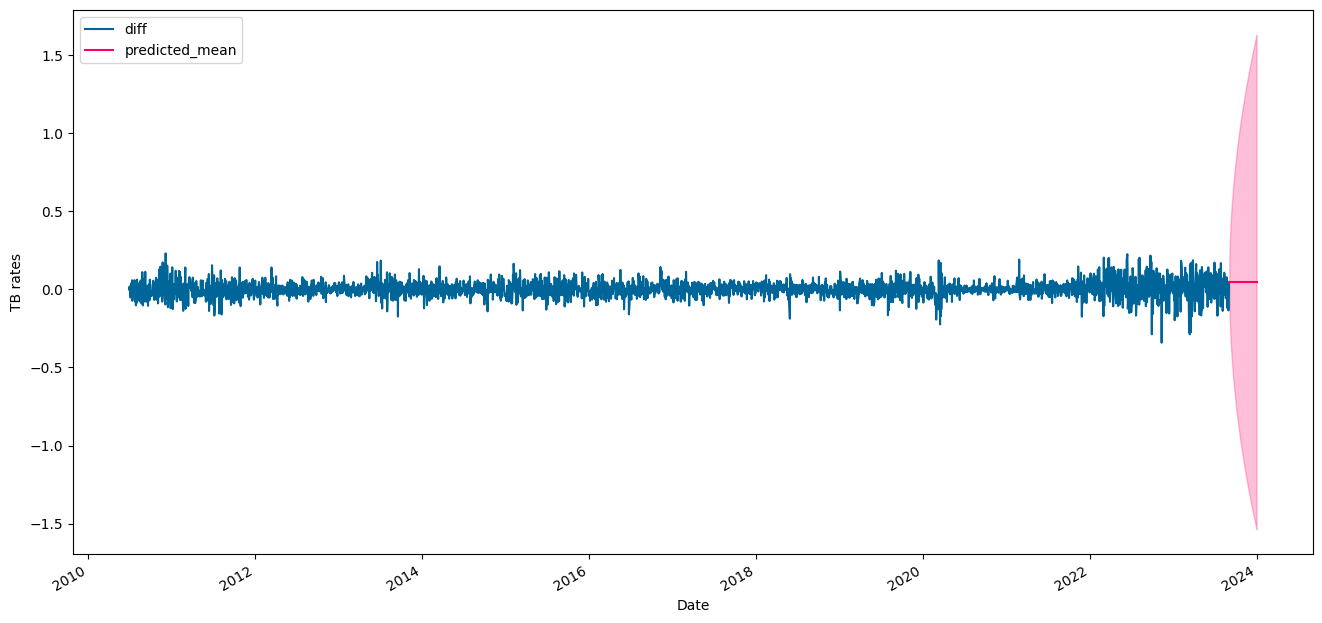

In [162]:
# plot time series and long-term forecast
ax = sarima_y_diff.plot(label='Pbserved', figsize=(16, 8), color='#006699')
pred_mean_s.plot(ax=ax, label='Forecast', color='#ff0066')
ax.fill_between(forecast_s_ci.index,
                forecast_s_ci.iloc[:, 0],
                forecast_s_ci.iloc[:, 1],
                color='#ff0066', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('TB rates')
plt.legend(loc='upper left')
plt.show()

## GARCH

https://github.com/ahn283/finance/blob/main/python_for_finance_cookbook/volatility_model_garch.ipynb